# **Bibliotecas**

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.1 MB/s eta 0:00:00


In [2]:
import urllib.request
import os
import zipfile
import pandas as pd

import glob
from tqdm.auto import tqdm
tqdm.pandas()
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

import numpy as np
from skimage.transform import resize

import optuna

# **Base de dados (placas de trânsito)**

In [3]:
# URL para o conjunto de dados
url = ("https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip")

# Verifica se o arquivo já existe para evitar baixar novamente
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    # Define o nome do arquivo
    filename = "./GTSRB_Final_Training_Images.zip"
    # Baixa o arquivo da URL e salva com o nome definido
    urllib.request.urlretrieve(url, filename)

#Extraindo arquivos

# Caminho do arquivo zip
zip_path = 'GTSRB_Final_Training_Images.zip'

# Pasta onde os arquivos serão extraídos
extract_to = 'GTSRB_Final_Training_Images/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Arquivos extraídos para: {extract_to}")

Arquivos extraídos para: GTSRB_Final_Training_Images/


In [4]:
# Lista para armazenar os caminhos completos de todos os arquivos CSV encontrados
csv_files = []

# Percorrer a pasta principal e suas subpastas
for root, dirs, files in os.walk(extract_to):
    # Filtrar apenas os arquivos .csv em cada pasta
    for file in files:
        if file.endswith('.csv'):
            # Adicionar o caminho completo do arquivo à lista
            csv_files.append(os.path.join(root, file))

dfs = []

# Ler cada arquivo CSV e adicionar a um dataframe na lista
for arquivo in csv_files:
    df = pd.read_csv(arquivo, sep=";")  # ajuste o sep se necessário
    df['Path'] = '/'.join(arquivo.split('/')[:-1]) + '/' + df.Filename
    dfs.append(df)

# Concatenar todos os dataframes em um único dataframe final
df_final = pd.concat(dfs, ignore_index=True)

# Imprimir o formato do dataframe final e as primeiras linhas
print(df_final.shape)
df_final.head()

(39209, 9)


Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0  00000_00000.ppm     26      27       6       6      21      21       36   
1  00000_00001.ppm     29      27       6       5      23      22       36   
2  00000_00002.ppm     28      29       5       6      23      24       36   
3  00000_00003.ppm     31      31       5       6      25      26       36   
4  00000_00004.ppm     33      33       5       5      27      28       36   

                                                Path  
0  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
1  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
2  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
3  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
4  GTSRB_Final_Training_Images/GTSRB/Final_Traini...

In [5]:
classes = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}



In [6]:
df_final['ClassName'] = df_final['ClassId'].map(classes)

In [7]:
img_size = 32
def load_img(img_file):
  try:
    img = Image.open('./'+img_file).convert('RGB')
    img = np.array(img, dtype=np.uint8)

    img = resize(
        img,
        output_shape=(img_size, img_size, 3),
        mode='reflect',
        anti_aliasing=True,
        preserve_range=False  # -> output in [0,1]
    )

    img = (img * 255).astype(np.uint8)
    return img
  except:
    return None


In [8]:
df_final['Image'] = df_final.progress_apply(lambda x: load_img(x['Path']), axis=1)

df_final = df_final.dropna(subset=['Image']).reset_index(drop=True)

  0%|          | 0/39209 [00:00<?, ?it/s]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_final.Image,
                                                    df_final.ClassName,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=df_final.ClassName
                                                    )

In [10]:
import numpy as np
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.filters import gaussian

RANDOM_SEED = 42
rng_global = np.random.default_rng(RANDOM_SEED)

# ---------------------- Augmentations seguras para placas ----------------------
def _to_uint8(img_float):
    img_float = np.clip(img_float, 0.0, 1.0)
    return (img_float * 255.0).astype(np.uint8)

def _ensure_float01(img):
    if img.dtype == np.uint8:
        return img.astype(np.float32) / 255.0
    if img.max() > 1.0:
        return (img / 255.0).astype(np.float32)
    return img.astype(np.float32)

def augment_plate(img,
                  max_rot_deg=30,
                  max_translate_ratio=0.30,
                  scale_range=(0.9, 1.1),
                  brightness_jitter=0.10,
                  contrast_jitter=0.10,
                  noise_std_max=0.02,
                  blur_sigma_max=0.6,
                  rng=None):
    """
    Aumenta a imagem respeitando:
      - sem flip
      - rotação |θ| ≤ 30°
      - translate ≤ 30% de W/H
      - escala leve (0.9–1.1)
      - jitter de brilho/contraste
      - ruído e blur leves
    Retorna uint8 (H,W,3).
    """
    if rng is None:
        rng = rng_global

    h, w = img.shape[:2]
    imgf = _ensure_float01(img)

    # rotação + escala + translação (sem flips)
    angle = rng.uniform(-max_rot_deg, max_rot_deg)
    scale = rng.uniform(scale_range[0], scale_range[1])
    max_tx = max_translate_ratio * w
    max_ty = max_translate_ratio * h
    tx = rng.uniform(-max_tx, max_tx)
    ty = rng.uniform(-max_ty, max_ty)

    center = (w / 2.0, h / 2.0)
    t1 = AffineTransform(translation=(-center[0], -center[1]))
    r  = AffineTransform(rotation=np.deg2rad(angle), scale=(scale, scale))
    t2 = AffineTransform(translation=(center[0] + tx, center[1] + ty))
    M = (t1 + r) + t2

    warped = warp(
        imgf, inverse_map=M.inverse,
        order=1, mode="edge", preserve_range=True
    )

    # contraste/brilho: y = (x - 0.5)*c + 0.5 + b
    c = 1.0 + rng.uniform(-contrast_jitter, contrast_jitter)
    b = rng.uniform(-brightness_jitter, brightness_jitter)
    warped = (warped - 0.5) * c + 0.5 + b
    warped = np.clip(warped, 0.0, 1.0)

    # ruído
    std = rng.uniform(0.0, noise_std_max)
    if std > 1e-6:
        warped = np.clip(warped + rng.normal(0.0, std, size=warped.shape), 0.0, 1.0)

    # blur leve por canal
    sigma = rng.uniform(0.0, blur_sigma_max)
    if sigma > 1e-6:
        blurred = np.empty_like(warped)
        for cidx in range(warped.shape[2]):
            blurred[..., cidx] = gaussian(warped[..., cidx], sigma=sigma, preserve_range=True)
        warped = np.clip(blurred, 0.0, 1.0)

    return _to_uint8(warped)

# ---------------------- Balanceamento via mediana ----------------------
# 1) DataFrame auxiliar com imagens e rótulos
train_df_temp = pd.DataFrame({'Image': list(X_train), 'ClassName': list(y_train)})

# 2) Contagens por classe e mediana alvo (ceil p/ evitar descartar demais)
class_counts = train_df_temp['ClassName'].value_counts()
median_target = int(np.ceil(class_counts.median()))

print(f"Contagens originais por classe:\n{class_counts.sort_index()}")
print(f"\nMediana das classes (alvo): {median_target}")

balanced_imgs = []
balanced_labels = []

rng = np.random.default_rng(RANDOM_SEED)

for cls, count in class_counts.items():
    cls_df = train_df_temp[train_df_temp['ClassName'] == cls]
    imgs_cls = list(cls_df['Image'])

    if count == median_target:
        # Mantém como está
        balanced_imgs.extend(imgs_cls)
        balanced_labels.extend([cls] * count)

    elif count > median_target:
        # 3) UNDERSAMPLING aleatório para mediana
        keep_idx = rng.choice(count, size=median_target, replace=False)
        for i in keep_idx:
            balanced_imgs.append(imgs_cls[i])
            balanced_labels.append(cls)

    else:
        # 4) OVERSAMPLING com augmentation até a mediana
        need = median_target - count
        balanced_imgs.extend(imgs_cls)         # mantém originais
        balanced_labels.extend([cls] * count)

        for _ in range(need):
            base = imgs_cls[rng.integers(0, len(imgs_cls))]  # amostra com reposição
            aug  = augment_plate(base, rng=rng)
            balanced_imgs.append(aug)
            balanced_labels.append(cls)

# 5) Embaralhar conjunto final
idx = np.arange(len(balanced_imgs))
rng.shuffle(idx)
X_train_balanced = [balanced_imgs[i] for i in idx]
y_train_balanced = [balanced_labels[i] for i in idx]

# 6) Relatório
print("\nDistribuição após balanceamento pela mediana:")
print(pd.Series(y_train_balanced).value_counts().sort_index())
print(f"\nTotal final: {len(X_train_balanced)} amostras "
      f"({len(np.unique(y_train_balanced))} classes).")


Contagens originais por classe:
ClassName
Ahead only                                             840
Beware of ice/snow                                     315
Bicycles crossing                                      189
Bumpy road                                             273
Children crossing                                      378
Dangerous curve to the left                            147
Dangerous curve to the right                           252
Double curve                                           231
End of all speed and passing limits                    168
End of no passing                                      168
End of no passing by vehicles over 3.5 metric tons     168
End of speed limit (80km/h)                            294
General caution                                        840
Go straight or left                                    147
Go straight or right                                   273
Keep left                                              210
Keep right    

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Converte os dados para tensores PyTorch e normaliza para o intervalo [-1, 1]
# Usando os dados de treino undersampled
tensor_x_treino = torch.from_numpy(np.array(list(X_train_balanced), dtype=np.uint8)).permute(0, 3, 1, 2).to(torch.float32) / 255.0
tensor_x_teste  = torch.from_numpy(np.array(list(X_test), dtype=np.uint8)).permute(0, 3, 1, 2).to(torch.float32) / 255.0

# Normalização para o intervalo [-1, 1]
tensor_x_treino = (tensor_x_treino - 0.5) / 0.5
tensor_x_teste  = (tensor_x_teste  - 0.5) / 0.5

# Converte os rótulos para tensores PyTorch (tipo long para classificação)
# Mapear os nomes das classes para IDs numéricos
class_to_id = {name: id for id, name in classes.items()}
tensor_y_treino = torch.from_numpy(np.array([class_to_id[label] for label in y_train_balanced])).to(torch.long)
tensor_y_teste = torch.from_numpy(np.array([class_to_id[label] for label in y_test])).to(torch.long)


# Cria os TensorDatasets
dataset_treino = TensorDataset(tensor_x_treino, tensor_y_treino)
dataset_teste = TensorDataset(tensor_x_teste, tensor_y_teste)

# Cria os DataLoaders - Estes serão recriados na célula seguinte para incluir o conjunto de validação
# trainloader = DataLoader(dataset_treino, batch_size=64, shuffle=True, num_workers=2)
# testloader  = DataLoader(dataset_teste, batch_size=64, shuffle=False, num_workers=2)

print("TensorDatasets criados com sucesso usando dados de treino undersampled!")

TensorDatasets criados com sucesso usando dados de treino undersampled!


torch.float32


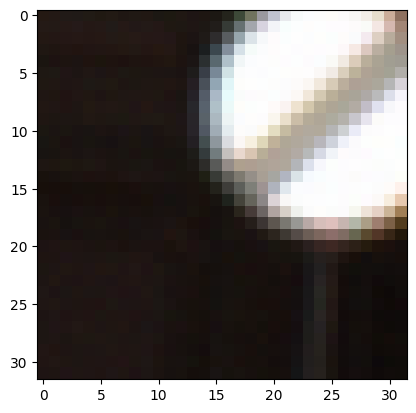

In [12]:
import matplotlib.pyplot as plt

image, label = dataset_treino[0] # Usar dataset_treino para pegar um exemplo

# Denormalize the image data from [-1, 1] to [0, 1] for plotting
image_denormalized = (image * 0.5) + 0.5

plt.imshow(image_denormalized.permute(1, 2, 0)) # Ajusta a ordem dos canais para (altura, largura, canais) para matplotlib
print(image.dtype)

# **Modelo**

In [13]:
# ===== Célula 1: Imports, configs e utilitários =====
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

# Reprodutibilidade
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)

# Dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# Saídas
OUT_DIR = "./resultados_mlp_optuna"
os.makedirs(OUT_DIR, exist_ok=True)
METRICS_CSV = os.path.join(OUT_DIR, "todas_metricas_por_epoca.csv")
TRIALS_CSV  = os.path.join(OUT_DIR, "resumo_trials.csv")
BEST_MODEL  = os.path.join(OUT_DIR, "best_model_state_dict.pt")

# Número de classes e dimensão de entrada (imagens 3x32x32 do seu pipeline)
N_CLASSES = 43          # len(classes)
INPUT_DIM = 3 * 32 * 32 # Flatten (C*H*W)

DEVICE: cuda


In [14]:
# ===== Célula 2: Criação do conjunto de validação =====
# Parte do pressuposto de que você já tem: dataset_treino e dataset_teste (TensorDataset)
# e DataLoaders trainloader / testloader criados nas células anteriores do seu notebook.

# Vamos criar train/val a partir do dataset_treino (80/20):
val_ratio = 0.2

# Cria um TensorDataset com dados de treino e rótulos
full_train_dataset = TensorDataset(tensor_x_treino, tensor_y_treino)

n_total = len(full_train_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# Divide o dataset completo de treino em treino e validação
train_ds, val_ds = random_split(full_train_dataset, [n_train, n_val],
                                generator=torch.Generator().manual_seed(RANDOM_SEED))

# DataLoaders (mantendo batch e workers semelhantes aos seus)
BATCH_SIZE_DEFAULT = 64

pin = torch.cuda.is_available()

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE_DEFAULT, shuffle=True,
    num_workers=0, pin_memory=pin, persistent_workers=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE_DEFAULT, shuffle=False,
    num_workers=0, pin_memory=pin, persistent_workers=False
)
test_loader = DataLoader(
    dataset_teste, batch_size=BATCH_SIZE_DEFAULT, shuffle=False,
    num_workers=0, pin_memory=pin, persistent_workers=False
)

len(train_ds), len(val_ds), len(dataset_teste)

len(train_ds), len(val_ds), len(dataset_teste)

(14448, 3612, 11763)

In [15]:
# ===== Célula 3: Construtor do MLP (nn.Sequential) =====
def build_mlp_sequential(input_dim:int,
                         hidden_sizes:list,
                         output_dim:int,
                         activation:str="relu",
                         dropout_p:float=0.0) -> nn.Sequential:
    """
    Cria um MLP via nn.Sequential:
    - Começa com nn.Flatten() para achatar (N, C, H, W) -> (N, C*H*W)
    - hidden_sizes: lista com nº de neurônios por camada oculta (ex.: [256,128])
    - activation: 'relu' ou 'sigmoid'
    - dropout_p: 0.0..0.5
    - output_dim: número de classes (43)
    """
    acts = {"relu": nn.ReLU, "sigmoid": nn.Sigmoid}
    layers = [nn.Flatten()]
    prev = input_dim
    for h in hidden_sizes:
        layers += [nn.Linear(prev, h), acts[activation]()]
        if dropout_p > 0:
            layers.append(nn.Dropout(dropout_p))
        prev = h
    layers.append(nn.Linear(prev, output_dim))
    return nn.Sequential(*layers).to(DEVICE)

In [16]:
# ===== Célula 4: Funções de treino/val/test =====
def train_one_epoch(model, loader, optimizer, criterion):
    """
    Treina 1 época:
    - Retorna (loss_médio, acc)
    """
    model.train()
    losses, preds_all, y_all = [], [], []
    pbar = tqdm(loader, desc="Treinando", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        preds = torch.argmax(logits, 1)
        preds_all.append(preds.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())
        pbar.set_postfix(loss=np.mean(losses))

    preds_all = np.concatenate(preds_all); y_all = np.concatenate(y_all)
    acc = accuracy_score(y_all, preds_all)
    return float(np.mean(losses)), float(acc)


@torch.no_grad()
def evaluate(model, loader, criterion):
    """
    Avaliação:
    - Retorna (loss_médio, acc)
    """
    model.eval()
    losses, preds_all, y_all = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        losses.append(loss.item())
        preds = torch.argmax(logits, 1)
        preds_all.append(preds.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())

    preds_all = np.concatenate(preds_all); y_all = np.concatenate(y_all)
    acc = accuracy_score(y_all, preds_all)
    return float(np.mean(losses)), float(acc)

In [17]:
# ===== Célula 5: Execução de um treino completo com logging =====
def run_training(params:dict,
                 train_loader, val_loader, test_loader,
                 input_dim:int, n_classes:int,
                 n_epochs:int, # Added n_epochs as a parameter
                 trial_id=None):
    """
    Executa treino completo conforme 'params' e registra histórico por época.
    params esperados:
      - hidden_sizes: list[int]
      - activation: 'relu'|'sigmoid'
      - dropout_p: float [0, 0.5]
      - lr: float
      - batch_size: int (não usado aqui pois DataLoader já está criado)
    """
    lr       = params.get("lr", 1e-3)
    # n_epochs = params.get("n_epochs", 12) # Removed n_epochs from params
    hidden   = params["hidden_sizes"]
    act      = params["activation"]
    drop     = params["dropout_p"]

    model = build_mlp_sequential(input_dim, hidden, n_classes, activation=act, dropout_p=drop)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    best_val_acc, best_state = -1.0, None

    for epoch in tqdm(range(1, n_epochs+1), desc=f"Trial {trial_id} | Épocas", leave=False):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc = evaluate(model, val_loader, criterion)

        history.append({
            "trial_id": trial_id,
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "val_loss": va_loss,
            "val_acc": va_acc,
            **params,
        })

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Avaliar no teste usando o melhor estado
    if best_state is not None:
        model.load_state_dict(best_state)
    te_loss, te_acc = evaluate(model, test_loader, criterion)

    return {
        "history": history,
        "best_val_acc": best_val_acc,
        "test_loss": te_loss,
        "test_acc": te_acc,
        "best_state": best_state,
    }

In [18]:
def suggest_params_optuna(trial):
    """
    Espaço de busca:
      - nº de camadas: 1..4
      - neurônios: 32..512 (log)
      - ativação: relu|sigmoid
      - dropout: 0.0..0.5
      - lr: 1e-4..3e-2 (log)
      - batch_size: 64|128|256  (não usado aqui, mas salvo no log)
    """
    n_layers = trial.suggest_int("n_hidden_layers", 1, 4)
    hidden = [trial.suggest_int(f"n_units_l{i+1}", 32, 512, log=True) for i in range(n_layers)]
    return {
        "hidden_sizes": hidden,
        "activation": trial.suggest_categorical("activation", ["relu", "sigmoid"]),
        "dropout_p": trial.suggest_float("dropout_p", 0.0, 0.5),
        "lr": trial.suggest_float("lr", 1e-4, 3e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256]),
    }

def random_params_fallback():
    """Fallback simples caso Optuna não esteja disponível."""
    n_layers = random.randint(1, 4)
    hidden = [int(2 ** random.randint(5, 9)) for _ in range(n_layers)]  # 32..512
    return {
        "hidden_sizes": hidden,
        "activation": random.choice(["relu", "sigmoid"]),
        "dropout_p": random.uniform(0.0, 0.5),
        "lr": 10 ** random.uniform(-4, -1.5),
        "batch_size": random.choice([64, 128, 256]),
    }

In [19]:
# ===== Célula 7: Execução da busca, CSVs e melhor modelo =====
def run_hparam_search(n_trials=5, n_epochs=50, output_prefix=""):
    """
    Executa n_trials de busca (Optuna ou fallback), salva CSVs e re-treina o melhor.
    Adiciona um prefixo aos arquivos de saída se especificado.
    """
    all_hist = []
    trials_rows = []

    # Define os caminhos dos arquivos de saída com o prefixo
    metrics_csv_path = os.path.join(OUT_DIR, f"{output_prefix}todas_metricas_por_epoca.csv")
    trials_csv_path  = os.path.join(OUT_DIR, f"{output_prefix}resumo_trials.csv")
    best_model_path  = os.path.join(OUT_DIR, f"{output_prefix}best_model_state_dict.pt")

    if optuna is not None:
        print("Optuna encontrado. Iniciando estudo...")
        def objective(trial):
            params = suggest_params_optuna(trial)
            res = run_training(params, train_loader, val_loader, test_loader,
                               INPUT_DIM, N_CLASSES, n_epochs=n_epochs, trial_id=trial.number)
            all_hist.extend(res["history"])

            # Get metrics from the last epoch for this trial
            last_epoch_metrics = res["history"][-1] if res["history"] else {}

            trials_rows.append({
                "trial_id": trial.number, **params,
                "best_val_acc": res["best_val_acc"],
                "test_acc": res["test_acc"],
                "test_loss": res["test_loss"],
                "train_acc": last_epoch_metrics.get("train_acc"),
                "val_acc": last_epoch_metrics.get("val_acc"),
                "train_loss": last_epoch_metrics.get("train_loss"),
                "val_loss": last_epoch_metrics.get("val_loss"),
            })
            print(f"Trial {trial.number} - Test Acc: {res['test_acc']:.4f}, Test Loss: {res['test_loss']:.4f}")
            return res["best_val_acc"]

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        best_trial = study.best_trial

        # Reconstruir params do melhor trial
        hidden = [best_trial.params[k] for k in sorted(best_trial.params) if k.startswith("n_units_l")]
        best_params = {
            "hidden_sizes": hidden,
            "activation": best_trial.params["activation"],
            "dropout_p": best_trial.params["dropout_p"],
            "lr": best_trial.params["lr"],
            "batch_size": best_trial.params["batch_size"],
            "n_epochs": n_epochs, # Use the fixed n_epochs
        }
        print(f"Melhor trial #{best_trial.number} | best_val_acc={study.best_value:.4f}")
    else:
        print("Optuna NÃO encontrado. Usando fallback aleatório.")
        best_val, best_params = -1.0, None
        for t in tqdm(range(n_trials), desc="Trials (fallback)"):
            params = random_params_fallback()
            res = run_training(params, train_loader, val_loader, test_loader,
                               INPUT_DIM, N_CLASSES, n_epochs=n_epochs, trial_id=t)
            all_hist.extend(res["history"])

            # Get metrics from the last epoch for this trial
            last_epoch_metrics = res["history"][-1] if res["history"] else {}

            trials_rows.append({
                "trial_id": t, **params,
                "best_val_acc": res["best_val_acc"],
                "test_acc": res["test_acc"],
                "test_loss": res["test_loss"],
                "train_acc": last_epoch_metrics.get("train_acc"),
                "val_acc": last_epoch_metrics.get("val_acc"),
                "train_loss": last_epoch_metrics.get("train_loss"),
                "val_loss": last_epoch_metrics.get("val_loss"),
            })
            print(f"Trial {t} - Test Acc: {res['test_acc']:.4f}, Test Loss: {res['test_loss']:.4f}")
            if res["best_val_acc"] > best_val:
                best_val, best_params = res["best_val_acc"], params

    # Salvar CSVs
    pd.DataFrame(all_hist).to_csv(metrics_csv_path, index=False)
    trials_df = pd.DataFrame(trials_rows).sort_values("best_val_acc", ascending=False)

    # Reorder columns
    metric_cols = ["train_acc", "val_acc", "test_acc", "train_loss", "val_loss", "test_loss"]
    other_cols = [col for col in trials_df.columns if col not in metric_cols]
    trials_df = trials_df[other_cols[:6] + metric_cols + other_cols[6:]] # Adjust indices based on your dataframe structure

    trials_df.to_csv(trials_csv_path, index=False)

    # Re-treinar melhor configuração (para salvar e plotar)
    print("Treinando melhor configuração para salvar modelo e curvas...")
    best_run = run_training(best_params, train_loader, val_loader, test_loader,
                            INPUT_DIM, N_CLASSES, n_epochs=n_epochs, trial_id=9999)
    torch.save(best_run["best_state"], best_model_path)
    print(f"Melhor configuração - Test Acc: {best_run['test_acc']:.4f}, Test Loss: {best_run['test_loss']:.4f}")


    return trials_df, pd.DataFrame(best_run["history"])

# Execute (ajuste n_trials conforme seu tempo)
trials_df, best_hist_df = run_hparam_search(n_trials=16, n_epochs=40, output_prefix="experimento_01_")
trials_df.head()

[I 2025-10-16 03:47:35,179] A new study created in memory with name: no-name-c6ed71eb-684a-439d-b559-0c71ef5959f2


Optuna encontrado. Iniciando estudo...


  0%|          | 0/16 [00:00<?, ?it/s]

Trial 0 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 0 - Test Acc: 0.8231, Test Loss: 0.6736
[I 2025-10-16 03:48:23,286] Trial 0 finished with value: 0.6846622369878184 and parameters: {'n_hidden_layers': 4, 'n_units_l1': 35, 'n_units_l2': 94, 'n_units_l3': 186, 'n_units_l4': 343, 'activation': 'relu', 'dropout_p': 0.19672019458063228, 'lr': 0.00011390832326181188, 'batch_size': 128}. Best is trial 0 with value: 0.6846622369878184.


Trial 1 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 1 - Test Acc: 0.0286, Test Loss: 3.6991
[I 2025-10-16 03:49:03,107] Trial 1 finished with value: 0.03765227021040975 and parameters: {'n_hidden_layers': 4, 'n_units_l1': 206, 'n_units_l2': 181, 'n_units_l3': 158, 'n_units_l4': 299, 'activation': 'relu', 'dropout_p': 0.45108675601584486, 'lr': 0.004926723240009466, 'batch_size': 256}. Best is trial 0 with value: 0.6846622369878184.


Trial 2 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 2 - Test Acc: 0.8844, Test Loss: 0.4469
[I 2025-10-16 03:49:42,082] Trial 2 finished with value: 0.7621816168327796 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 173, 'n_units_l2': 126, 'n_units_l3': 91, 'activation': 'relu', 'dropout_p': 0.3277579460676798, 'lr': 0.00026814131573816224, 'batch_size': 256}. Best is trial 2 with value: 0.7621816168327796.


Trial 3 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 3 - Test Acc: 0.8864, Test Loss: 0.4646
[I 2025-10-16 03:50:23,586] Trial 3 finished with value: 0.7691029900332226 and parameters: {'n_hidden_layers': 1, 'n_units_l1': 116, 'activation': 'relu', 'dropout_p': 0.04097614534707733, 'lr': 0.0009590494086375451, 'batch_size': 64}. Best is trial 3 with value: 0.7691029900332226.


Trial 4 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 4 - Test Acc: 0.1112, Test Loss: 3.0712
[I 2025-10-16 03:51:00,025] Trial 4 finished with value: 0.10686600221483943 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 52, 'n_units_l2': 85, 'activation': 'relu', 'dropout_p': 0.38679795964519786, 'lr': 0.008440188725169197, 'batch_size': 128}. Best is trial 3 with value: 0.7691029900332226.


Trial 5 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 5 - Test Acc: 0.0176, Test Loss: 3.7547
[I 2025-10-16 03:51:41,484] Trial 5 finished with value: 0.02547065337763012 and parameters: {'n_hidden_layers': 4, 'n_units_l1': 68, 'n_units_l2': 72, 'n_units_l3': 232, 'n_units_l4': 38, 'activation': 'relu', 'dropout_p': 0.25448174747755625, 'lr': 0.011384096337115115, 'batch_size': 256}. Best is trial 3 with value: 0.7691029900332226.


Trial 6 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 6 - Test Acc: 0.8828, Test Loss: 0.4640
[I 2025-10-16 03:52:31,147] Trial 6 finished with value: 0.7779623477297896 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 43, 'n_units_l2': 160, 'n_units_l3': 43, 'activation': 'relu', 'dropout_p': 0.004318258506729344, 'lr': 0.0005050310322576027, 'batch_size': 256}. Best is trial 6 with value: 0.7779623477297896.


Trial 7 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 7 - Test Acc: 0.8628, Test Loss: 0.6161
[I 2025-10-16 03:53:12,091] Trial 7 finished with value: 0.7272978959025471 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 309, 'n_units_l2': 36, 'activation': 'sigmoid', 'dropout_p': 0.05196259733541014, 'lr': 0.00038197885000216094, 'batch_size': 128}. Best is trial 6 with value: 0.7779623477297896.


Trial 8 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 8 - Test Acc: 0.8863, Test Loss: 0.5559
[I 2025-10-16 03:53:51,398] Trial 8 finished with value: 0.7527685492801772 and parameters: {'n_hidden_layers': 1, 'n_units_l1': 177, 'activation': 'sigmoid', 'dropout_p': 0.22388607041757075, 'lr': 0.0002311212369317274, 'batch_size': 256}. Best is trial 6 with value: 0.7779623477297896.


Trial 9 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 9 - Test Acc: 0.9008, Test Loss: 0.4080
[I 2025-10-16 03:54:37,853] Trial 9 finished with value: 0.7862679955703211 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 70, 'n_units_l2': 184, 'activation': 'relu', 'dropout_p': 0.11387587304934332, 'lr': 0.0011178890359713697, 'batch_size': 128}. Best is trial 9 with value: 0.7862679955703211.


Trial 10 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 10 - Test Acc: 0.8651, Test Loss: 0.4916
[I 2025-10-16 03:55:23,359] Trial 10 finished with value: 0.7547065337763013 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 85, 'n_units_l2': 427, 'activation': 'sigmoid', 'dropout_p': 0.13233824699756896, 'lr': 0.0024983718565486854, 'batch_size': 64}. Best is trial 9 with value: 0.7862679955703211.


Trial 11 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 11 - Test Acc: 0.8976, Test Loss: 0.4014
[I 2025-10-16 03:56:14,161] Trial 11 finished with value: 0.78156146179402 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 33, 'n_units_l2': 228, 'n_units_l3': 44, 'activation': 'relu', 'dropout_p': 0.011956084399750481, 'lr': 0.0010936138007555198, 'batch_size': 128}. Best is trial 9 with value: 0.7862679955703211.


Trial 12 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 12 - Test Acc: 0.8602, Test Loss: 0.5219
[I 2025-10-16 03:57:03,562] Trial 12 finished with value: 0.7397563676633444 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 33, 'n_units_l2': 307, 'n_units_l3': 33, 'activation': 'relu', 'dropout_p': 0.10809405510876234, 'lr': 0.0015590845247294065, 'batch_size': 128}. Best is trial 9 with value: 0.7862679955703211.


Trial 13 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 13 - Test Acc: 0.0108, Test Loss: 3.7589
[I 2025-10-16 03:57:46,370] Trial 13 finished with value: 0.026854928017718716 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 71, 'n_units_l2': 246, 'activation': 'relu', 'dropout_p': 0.11386813366046358, 'lr': 0.023557932402685753, 'batch_size': 128}. Best is trial 9 with value: 0.7862679955703211.


Trial 14 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 14 - Test Acc: 0.8430, Test Loss: 0.5325
[I 2025-10-16 03:58:36,084] Trial 14 finished with value: 0.739202657807309 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 54, 'n_units_l2': 471, 'n_units_l3': 460, 'activation': 'sigmoid', 'dropout_p': 0.16851893014997954, 'lr': 0.000980687077340764, 'batch_size': 128}. Best is trial 9 with value: 0.7862679955703211.


Trial 15 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Trial 15 - Test Acc: 0.8294, Test Loss: 0.8119
[I 2025-10-16 03:59:20,718] Trial 15 finished with value: 0.7231450719822813 and parameters: {'n_hidden_layers': 1, 'n_units_l1': 105, 'activation': 'relu', 'dropout_p': 0.06926020372258554, 'lr': 0.0026719853889144514, 'batch_size': 128}. Best is trial 9 with value: 0.7862679955703211.
Melhor trial #9 | best_val_acc=0.7863
Treinando melhor configuração para salvar modelo e curvas...


Trial 9999 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Treinando:   0%|          | 0/226 [00:00<?, ?it/s]

Melhor configuração - Test Acc: 0.8945, Test Loss: 0.3891


trial_id    hidden_sizes activation  dropout_p        lr  batch_size  \
9          9       [70, 184]       relu   0.113876  0.001118         128   
11        11   [33, 228, 44]       relu   0.011956  0.001094         128   
6          6   [43, 160, 43]       relu   0.004318  0.000505         256   
3          3           [116]       relu   0.040976  0.000959          64   
2          2  [173, 126, 91]       relu   0.327758  0.000268         256   

    train_acc   val_acc  test_acc  train_loss  val_loss  test_loss  \
9    0.814023  0.775748  0.900791    0.608421  0.864225   0.407969   
11   0.851744  0.753599  0.897560    0.473481  1.037397   0.401412   
6    0.843785  0.773810  0.882768    0.491048  0.936051   0.463976   
3    0.879845  0.765781  0.886424    0.401638  1.229592   0.464594   
2    0.686393  0.752769  0.884383    1.032374  0.872621   0.446897   

    best_val_acc  
9       0.786268  
11      0.781561  
6       0.777962  
3       0.769103  
2       0.762182

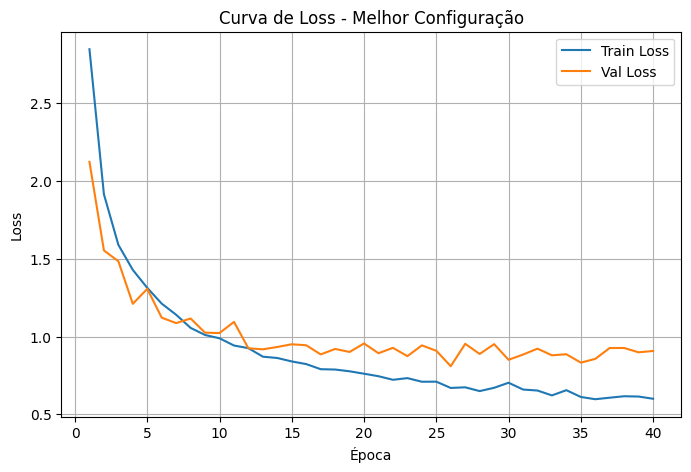

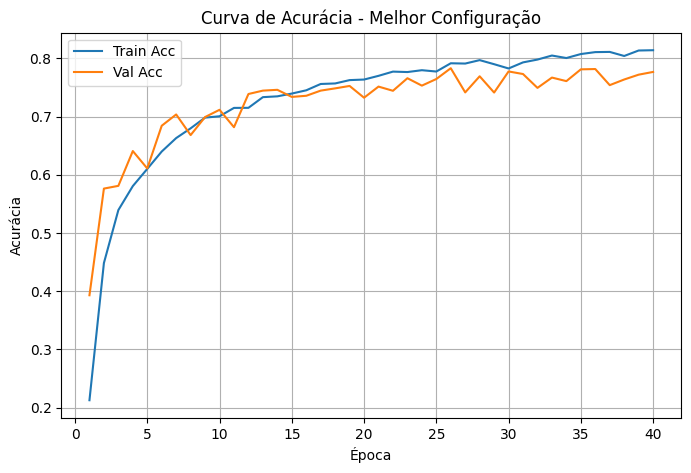

Arquivos salvos em: /content/resultados_mlp_optuna
 - Métricas por época: ./resultados_mlp_optuna/test_run_todas_metricas_por_epoca.csv
 - Resumo dos trials:  ./resultados_mlp_optuna/test_run_resumo_trials.csv
 - Melhor modelo:      ./resultados_mlp_optuna/test_run_best_model_state_dict.pt


In [20]:
# ===== Célula 8: Visualizações e caminhos dos arquivos =====
plt.figure(figsize=(8,5))
plt.plot(best_hist_df["epoch"], best_hist_df["train_loss"], label="Train Loss")
plt.plot(best_hist_df["epoch"], best_hist_df["val_loss"],   label="Val Loss")
plt.title("Curva de Loss - Melhor Configuração")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(best_hist_df["epoch"], best_hist_df["train_acc"], label="Train Acc")
plt.plot(best_hist_df["epoch"], best_hist_df["val_acc"],   label="Val Acc")
plt.title("Curva de Acurácia - Melhor Configuração")
plt.xlabel("Época"); plt.ylabel("Acurácia"); plt.grid(True); plt.legend()
plt.show()

# Atualiza a impressão dos caminhos dos arquivos para refletir o prefixo
# Para fazer isso de forma mais flexível, vamos redefinir os caminhos aqui
output_prefix = "test_run_" # Certifique-se que este prefixo corresponde ao usado em run_hparam_search
OUT_DIR = "./resultados_mlp_optuna" # Mantenha a pasta base

metrics_csv_path = os.path.join(OUT_DIR, f"{output_prefix}todas_metricas_por_epoca.csv")
trials_csv_path  = os.path.join(OUT_DIR, f"{output_prefix}resumo_trials.csv")
best_model_path  = os.path.join(OUT_DIR, f"{output_prefix}best_model_state_dict.pt")


print("Arquivos salvos em:", os.path.abspath(OUT_DIR))
print(" - Métricas por época:", metrics_csv_path)
print(" - Resumo dos trials: ", trials_csv_path)
print(" - Melhor modelo:     ", best_model_path)

# Task
Oversample the minority classes in the training dataset using data augmentation techniques (rotation and pan, with limits of 30% of the original image size and no mirroring) to match the number of examples in the majority class. Apply appropriate techniques for images of license plates. Ensure the code is clean and well-explained.

## Identify the majority class

### Subtask:
Determine the class with the highest number of examples in the training set.


**Reasoning**:
Calculate the value counts for the training labels and find the maximum count to determine the majority class size.

